In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import sys
import xesmf as xe

In [2]:
%run HcastAnalysisImportDataTEST.ipynb

In [9]:
# ************************************************************************************************
# *************************** USER INPUTS ARE REQUIRED IN THIS CELL ******************************
# ************************************************************************************************

#### Select which variable should be plotted ####
# The current options are 'PRECT', 'VBOT', and 'UBOT'
varName = 'PRECT'

#### Select the date in 'YYYY-MM-DD' format (ISO 8601 for you nerds out there) ####
_dayOfTheSeason = '2010-02-20'

#### Select the number of days to be time averaged ####
numDayAvg = 2

#### Select which day hindcast should be used ####
DayXXHcast = [5,10,15,20]  # Must be a list of integer(s) from >=1 and <=20 (max of 6 integers)

# Choose region of interest 
lats = -20
latn =  20
lonw = -135 # *** For longitudes west of the Prime Meridian, enter a negative number ***
lone = -90  

# ************************************************************************************************
# ************************************************************************************************
# ************************************************************************************************

# Convert _dayOfTheSeason to datetime64 format
dayOfTheSeason = np.datetime64(_dayOfTheSeason)

# Convert varName to an index integer
varNameDict = {'PRECT':0, 'VBOT':1, 'UBOT':2}
varInd = varNameDict[varName]

In [10]:
## Select the data within the user defined region of interest

# First, check if the user has requested data that is out of the time bounds of hindcast dataset
# If so, null the variable index to prevent the script from running
if dayOfTheSeason+numDayAvg-1 > dataMega[varInd][1]['time'][-1] or dayOfTheSeason < dataMega[varInd][1]['time'][0]:
    varInd = None; DayXXHcast = None
    sys.exit("The user has attemped to access data that is outside of the time bounds of the hindcast dataset")

# Initialize empty array
selData = [None] * len(dataMega[varInd])

# Iterate through each hindcast day to select the data in the region of interest
# The iteration starts at 1 to agree with the indexing convention of the hindcast days (starting with 1)
for ii in range(1,len(dataMega[varInd])): 
    # Subtract 1 from numDayAvg since a slice will include the end point
    # Add 360 to the longitude so that it agrees with the dataset which ranges from 0 to 360
    selData[ii] = dataMega[varInd][ii].sel(time=slice(dayOfTheSeason, dayOfTheSeason+numDayAvg-1), lat = slice(lats-0.6, latn+0.6), lon=slice(lonw+360, lone+360))

# Select obs data
if varName == 'PRECT':
    selDataObs = dataMegaObs[0].sel(time=slice(dayOfTheSeason, dayOfTheSeason+numDayAvg-1), lat=slice(lats,latn), lon=slice(lonw,lone)) 
# elif varName == 'VBOT':
elif varName == 'VBOT' or varName == 'UBOT':
    selDataObs = dataMegaObs[varInd].sel(time=slice(dayOfTheSeason, dayOfTheSeason+numDayAvg), lat=slice(lats,latn), lon=slice(lonw+360,lone+360))
else:
    sys.exit("The user has incorrectly entered the variable name. The options are: 'PRECT' 'VBOT' 'UBOT'")

In [11]:
# Zonally average the data for the length of the numDayAvg specificed 

# Initialize lists for hindcast data
plotData = [None] * len(selData)

# Perform time and longitudinal average for all hindcast days
for ii in range(1, len(selData)):
    plotData[ii] = selData[ii].mean(dim=['lon','time'])

# Perform average for obs data
# prectObsPlot = prectObsSel.mean(dim=['lon','time'])
if varName =='PRECT':
    plotDataObs = selDataObs.mean(dim=['lon','time'])
elif varName =='VBOT' or varName =='UBOT':
    plotDataObs = selDataObs.mean(dim=['lon','time'])

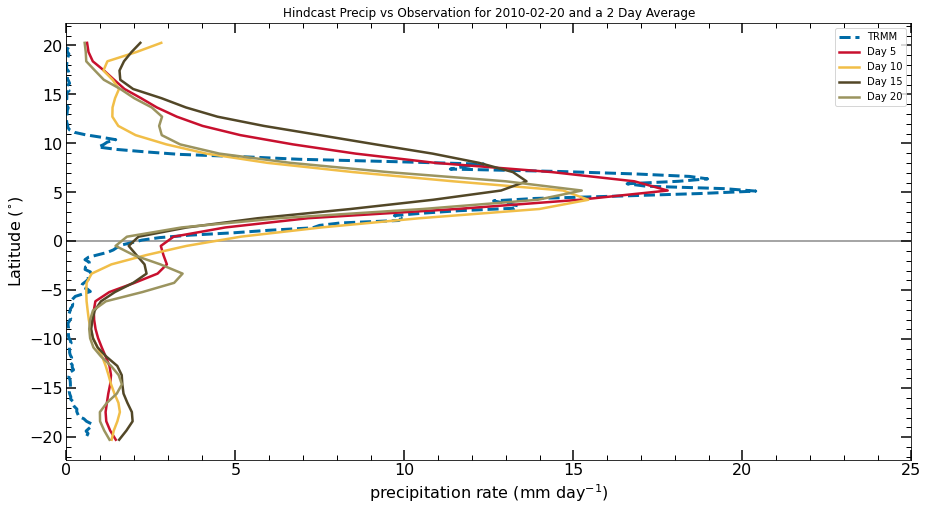

In [12]:
# Plot a comparison between hindcasts and observation

# Setup the figure
fig = plt.figure(figsize=(13, 7.2), tight_layout='true')
plt.minorticks_on()
ax=fig.add_axes()
plt.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=16, right='True', top='True')
plt.tick_params(axis='both', which='minor', length= 5, width=1.0, direction='in', labelsize=16, right='True', top='True')
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.axhline(0, color='0.65', linewidth = 2.0, zorder=-1)
plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-2)
plt.ylabel('Latitude $(^{\circ})$', fontsize=16)
plotColors = ['#C8102E','#F1BE48','#524727','#9B945F','#8B5B29', '#BE531C'] # Go Cyclones! :)
plotLegend = []
plotLegend.append('TRMM')

# Set variable plot properties
if varName == 'PRECT':
    plt.xlim([0,25])
    plt.xlabel('precipitation rate (mm day$^{-1}$)', fontsize=16)
    plt.title("Hindcast Precip vs Observation for "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" Day Average")
    p0 = plt.plot(plotDataObs, plotDataObs.lat, color='#006BA6', linestyle='dashed', linewidth = 3, label = 'TRMM')
elif varName == 'VBOT':
    plt.xlim([-10,10])
    plt.xlabel('meridional winds (m sec$^{-1}$)', fontsize=16)
    plt.title("Hindcast VBOT vs Observation for "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" Day Average")
    p0 = plt.plot(plotDataObs, plotDataObs.lat, color='#006BA6', linestyle='dashed', linewidth = 3, label = 'ERA5')
elif varName == 'UBOT':
    plt.xlim([-10,10])
    plt.xlabel('zonal winds (m sec$^{-1}$)', fontsize=16)
    plt.title("Hindcast UBOT vs Observation for "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" Day Average")
    p0 = plt.plot(plotDataObs, plotDataObs.lat, color='#006BA6', linestyle='dashed', linewidth = 3, label = 'ERA5')
else:
    sys.exit("The user has incorrectly entered the variable name. The options are: 'PRECT' 'VBOT' 'UBOT'")

# Loop through the DayXXHcast list to overlay multiple days of hindcast data
for ii, DayXX in enumerate(DayXXHcast):
    
    p1 = plt.plot(plotData[DayXX], plotData[DayXX].lat, color = plotColors[ii], linewidth = 2.5, label = 'Day '+str(DayXX))    

plt.legend()
plt.show()    

In [13]:
## Increase the spatial resolution of the hindcast dataset so that it equals the resolution of obs
## Then, find the absolute error between the hindcast precip and the obs precip

# Define the region of interest for the error analysis
latsErr = -5; latnErr = -1; lonwErr = -135; loneErr = -90
latsErrVbot = -5; latnErrVbot = 5
 
# Define a new dataset the has the spatial grid of the obs data
ds_out = xr.Dataset({'lat': (['lat'], selDataObs.lat),
                     'lon': (['lon'], selDataObs.lon) })

# Initialize an empty list to hold data for each hindcast day
regridData = [None] * len(DayXXHcast)

# Iterate through each hindcast day. Here "data" is the hindcast precipitation dataSet
for ii, day in enumerate(DayXXHcast):
        
    # Create a regridder object that will convert a dataArray with the resolution of the hindcasts to the resolution of the obs
    regridder = xe.Regridder(selData[day], ds_out, 'bilinear', reuse_weights=True)  
    
    # Regrid the data in the region of interest. Pass a dataArray to the regridData list
    regridData[ii] = regridder(selData[day].to_dataset(name='preGrid'))['preGrid']
    
# Ignore the warning about the array not being c_contiguous. It is mainly saying that the program will run a bit slower
# as the array is the regridder function is not in the desired format.

Create weight file: bilinear_44x37_160x180.nc
using dimensions ('lat', 'lon') from data variable preGrid as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_44x37_160x180.nc
using dimensions ('lat', 'lon') from data variable preGrid as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_44x37_160x180.nc
using dimensions ('lat', 'lon') from data variable preGrid as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_44x37_160x180.nc
using dimensions ('lat', 'lon') from data variable preGrid as the horizontal dimensions for this dataset.


/opt/miniconda3/envs/prod/lib/python3.8/site-packages/xesmf/smm.py:70: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


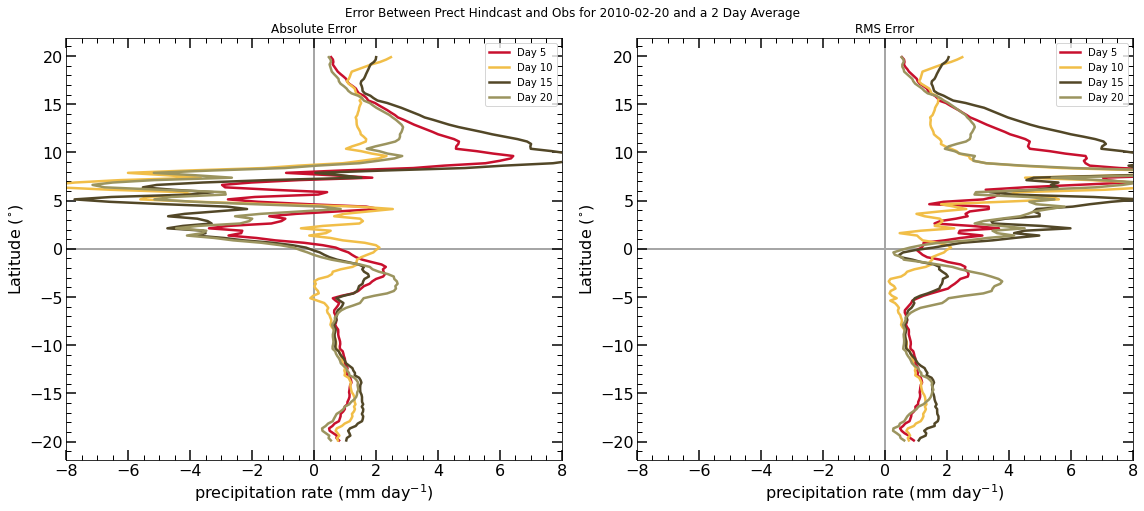

In [14]:
npan = 2 # number of panels
# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(16, 7.2), tight_layout='true') #plot the figure and apply some asthetic constraints

for j in range(0,npan,1): # Each iteration creates a new subplot
    # Setup the plot
    ax1 = fig.add_subplot(1,npan,j+1)
    plt.minorticks_on()
    ax1.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=16, right='True', top='True')
    ax1.tick_params(axis='both', which='minor', length= 5, width=1.0, direction='in', labelsize=16, right='True', top='True')
    ax1.tick_params(axis='x', labelsize=16)
    ax1.tick_params(axis='y', labelsize=16)
    plt.axhline(0, color='0.65', linewidth = 2.0, zorder=-1)
    plt.axvline(0, color='0.65', linewidth = 2.0, zorder=-2)
    
    if j == 0: # First subplot (absolute error)
        
        for ii, DayXX in enumerate(DayXXHcast): # Each iteration creates a new hindcast line plot on the graph 

            # Take a lon and time avg of the hindcast data
            lonAvgData = regridData[ii].mean(dim=['lon','time'])
            
            # Find the absolute error between the interpolated hindcast and the observation precip
            absErr = lonAvgData - plotDataObs
            
            # Plot the absolute error precip
            p1 = plt.plot(absErr, absErr.lat, color = plotColors[ii], linewidth = 2.5, label = 'Day '+str(DayXX))
            
        if varName == 'PRECT':
            plt.xlabel('precipitation rate (mm day$^{-1}$)', fontsize=16)
            plt.suptitle("Error Between Prect Hindcast and Obs for "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" Day Average")
        elif varName == 'VBOT':
            plt.xlabel('meridional winds (m sec$^{-1}$)', fontsize=16)
            plt.suptitle("Error Between Vbot Hindcast and Obs for "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" Day Average")
        elif varName == 'UBOT':
            plt.xlabel('zonal winds (m sec$^{-1}$)', fontsize=16)
            plt.suptitle("Error Between Ubot Hindcast and Obs for "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" Day Average")
            
        # Set plot settings
        plt.ylabel('Latitude $(^{\circ})$', fontsize=16)
        plt.title("\nAbsolute Error")
        plt.xlim([-8,8])
        plt.legend()
        
    elif j == 1: # Second subplot (RMS error)
        
        for ii,DayXX in enumerate(DayXXHcast): # Each iteration creates a new hindcast line plot on the graph
            
            # Initialize the variable that will store the total error over the numDayAvg range
            data_errSqr_tot = 0
            
            for kk in range(numDayAvg): # Each iteration cumulates the precipitation error for each day

                # Longitudinally average the regrided data for each hindcast day and each day in the numDayAvg range
                lonAvgData    = regridData[ii][kk].mean(dim='lon')
                lonAvgDataObs = selDataObs[kk].mean(dim='lon')
        
                # Square the difference between the interpolated hindcast data and the observation data
                dataErrSqr = np.square(lonAvgData - lonAvgDataObs)
                
                # Sum the squared differences and store this in the total precip error variable
                data_errSqr_tot = data_errSqr_tot + dataErrSqr
            
            # Divide the summed, squared differences by the value of numDayAvg and then 
            # take the square root to obtain the precip RMS error
            dataRMS = np.sqrt(data_errSqr_tot/numDayAvg)             
            
            # Once the RMS error has been calculated, plot the error data            
            p2 = plt.plot(dataRMS, dataRMS.lat, color = plotColors[ii], linewidth = 2.5, label = 'Day '+str(DayXX))
            
        if varName == 'PRECT':
            plt.xlabel('precipitation rate (mm day$^{-1}$)', fontsize=16)
        elif varName == 'VBOT':
            plt.xlabel('meridional winds (m sec$^{-1}$)', fontsize=16)
        elif varName == 'UBOT':
            plt.xlabel('zonal winds (m sec$^{-1}$)', fontsize=16)
            
        plt.ylabel('Latitude $(^{\circ})$', fontsize=16)
        plt.title("RMS Error")
        plt.xlim([-8,8])
        plt.legend()
        